# Investigating Carbon Emissions of Neutron Transport Simulations.
Rosie Schiffmann <br>
University of Manchester <br>
July 2025

# 1. Introduction
In this notebook, the carbon emissions produced by running some neutron transport simulation software is plotted. The software used is found inside "Project_3_11020606.ipynb", where CodeCarbon is implemented to track and export data about the energy consumption of simulating transmission, reflection and absortion rates of neutrons incident onto different thicknesses of lead, graphite and water "slabs". The simulation complexity is increased by increasing the number of neutrons incident onto the slabs.

CodeCarbon is an embedded package that can be used to estimate the carbon footprint (alongside other power and energy metrics) of your software. In this project, CodeCarbon was run on macOS. It had access to powermetrics, allowing for real time power consumption tracking of the CPU and GPU. 

The emissions, energy and power usage of the `plot_T_A_R_thicknesses` function inside of the `Project_3_11020606.ipynb` notebook were tracked using CodeCarbon. 

 Various plots are investigated to demonstrate that:
- power is constant no matter what you're doing 
- energy consumption increases with time 
- energy consumption scales with simulation complexity in the way that we expect 

In [37]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re

# 2. Data 
Inside "Project_3_11020606.ipynb", CodeCarbon is implemented to measure the energy consumption of the `plot_T_A_R_thicknesses` function as follows:
```
from codecarbon import EmissionsTracker
with EmissionsTracker(output_file="210725_neutron_penetration_emissions_100000.csv") as tracker:
    transmission_master_array, transmission_errors_master_array = plot_T_A_R_thicknesses(
        thicknesses, 100000, mfp_total, prob_absorb)
print("=====done=====") 
```

Each time this cell is run, a new row of CodeCarbon output data is added to the corresponding `"XXXXXX_neutron_penetration_emissions_XXXXX.csv"` file. Each row contains data on emissions, duration, cpu_power, ram_power, gpu_power, cpu_energy, ram_energy, gpu_energy and others.

Below, all of the `"XXXXXX_neutron_penetration_emissions_XXXXX.csv"` files inside the repository that match a given date are collected. The mean values for emissions, duration, CPU/GPU power and CPU/GPU energy are calculated for each selected file, and the number of neutrons in the simulation is extracted from the filename. The corresponding error on the mean is also propagated for each value. All of this data, as well as some per-neutron metrics, are added to a `"master_emissions_data.csv"` file, with each row corresponding to processed data from a different `"XXXXXX_neutron_penetration_emissions_XXXXX.csv"` file. This particular investigation uses data collected on 21/07/25.

In [38]:
#identify relevant csv files inside repository
csv_files = glob.glob("20250806_mac_neutron_emissions_*.csv")

def generate_master_csv(files):
	"""
	Function to generate a master csv file containing all data for plotting, for either the integration or generation
	phase of HERWIG.

	Parameters:
	- type (str): 'machine' or 'process'
	"""
	summary_data = []

	for file in files:
		#identify and find mean of relevant data from CodeCarbon raw outputs
		df = pd.read_csv(file)
		mean_emissions = df['emissions'].mean()
		mean_duration = df['duration'].mean()
		mean_cpu_power = df['cpu_power'].mean()
		mean_ram_power = df['ram_power'].mean()
		mean_gpu_power = df['gpu_power'].mean()
		mean_cpu_energy = df['cpu_energy'].mean()
		mean_ram_energy = df['ram_energy'].mean()
		mean_gpu_energy = df['gpu_energy'].mean()

		#obtain number of neutrons from filename
		match = re.search(r'_(\d+)neutrons', file)
		neutrons = int(match.group(1)) if match else None

        # Add a check to ensure neutrons was found before proceeding
		if neutrons is None:
			print(f"Warning: Could not extract neutron number from filename '{file}'. Skipping.")
			continue

		#propagate errors
		emissions_err = df['emissions'].std() / np.sqrt(len(df['emissions']))
		duration_err = df['duration'].std() / np.sqrt(len(df['duration']))
		cpu_power_err = df['cpu_power'].std() / np.sqrt(len(df['cpu_power']))
		ram_power_err = df['ram_power'].std() / np.sqrt(len(df['ram_power']))
		gpu_power_err = df['gpu_power'].std() / np.sqrt(len(df['gpu_power']))
		cpu_energy_err = df['cpu_energy'].std() / np.sqrt(len(df['cpu_energy']))
		ram_energy_err = df['ram_energy'].std() / np.sqrt(len(df['ram_energy']))
		gpu_energy_err = df['gpu_energy'].std() / np.sqrt(len(df['gpu_energy']))
		
		#add dictionary of data to summary_data list 
		summary_data.append({
			'filename': file,
			'number_of_neutrons': neutrons,
			'mean_emissions': mean_emissions,
			'emissions_per_neutron' : mean_emissions / neutrons,
			'emissions_per_neutron_err' : emissions_err / neutrons,
			'emissions_err' : emissions_err,
			'mean_duration': mean_duration,
			'duration_err' : duration_err,
			'duration_per_neutron' : mean_duration / neutrons,
			'duration_per_neutron_err' : duration_err / neutrons,
			'cpu_power': mean_cpu_power,
			'cpu_power_err' : cpu_power_err,
			'ram_power' : mean_ram_power,
			'ram_power_err' : ram_power_err,
			'gpu_power': mean_gpu_power,
			'gpu_power_err' : gpu_power_err,
			'cpu_energy' : mean_cpu_energy,
			'cpu_energy_err' : cpu_energy_err,
			'ram_energy' : mean_ram_energy,
			'ram_energy_err' : ram_energy_err,
			'gpu_energy' : mean_gpu_energy,
			'gpu_energy_err' : gpu_energy_err,
			'cpu_energy_per_neutron' : mean_cpu_energy / neutrons,
			'cpu_energy_per_neutron_err' : cpu_energy_err / neutrons,
			'ram_energy_per_neutron' : mean_ram_energy / neutrons,
			'ram_energy_per_neutron_err' : ram_energy_err / neutrons,
			'gpu_energy_per_neutron' : mean_gpu_energy / neutrons,
			'gpu_energy_per_neutron_err' : gpu_energy_err / neutrons,
			'duration_per_neutron' : mean_duration / neutrons,
			'duration_per_neutron_err': duration_err / neutrons,
			#units: energy (kWh), power (W). *1000*3600 to get into seconds
			'cpu_energy_over_power' : 1000*3600*mean_cpu_energy / mean_cpu_power,
			'gpu_energy_over_power' : 1000*3600*mean_gpu_energy / mean_gpu_power,
			'ram_energy_over_power' : 1000*3600*mean_ram_energy / mean_ram_power,
			'cpu_energy_over_power_err' : 1000*3600*(mean_cpu_energy / mean_cpu_power) * np.sqrt((cpu_energy_err/mean_cpu_energy)**2 + (cpu_power_err/mean_cpu_power)**2),
			'ram_energy_over_power_err' : 1000*3600*(mean_ram_energy / mean_ram_power) * np.sqrt((ram_energy_err/mean_ram_energy)**2 + (ram_power_err/mean_ram_power)**2),
			'gpu_energy_over_power_err' : 1000*3600*(mean_gpu_energy / mean_gpu_power) * np.sqrt((gpu_energy_err/mean_gpu_energy)**2 + (gpu_power_err/mean_gpu_power)**2)
		})

	#convert into dataframe and create master csv file.
	summary_df = pd.DataFrame(summary_data)
	summary_df = summary_df.sort_values(by='number_of_neutrons') #sort wrt number_of_neutrons
	summary_df.to_csv(f"mac_master_emissions_data.csv", index=False)
	return summary_df

df = generate_master_csv(csv_files)
df = df[df['number_of_neutrons'] <= 30000].copy()
df



,filename,number_of_neutrons,mean_emissions,emissions_per_neutron,emissions_per_neutron_err,emissions_err,mean_duration,duration_err,duration_per_neutron,duration_per_neutron_err,...,ram_energy_per_neutron,ram_energy_per_neutron_err,gpu_energy_per_neutron,gpu_energy_per_neutron_err,cpu_energy_over_power,gpu_energy_over_power,ram_energy_over_power,cpu_energy_over_power_err,ram_energy_over_power_err,gpu_energy_over_power_err
1,20250806_mac_neutron_emissions_1000neutrons_10...,1000,5.107210e-07,5.107210e-10,2.045110e-11,2.045110e-08,5.365259,0.016163,0.005365,1.616339e-05,...,1.998000e-09,1.209151e-11,2.403762e-11,1.877082e-11,2.382341,3.807102,2.397600,2.275827,0.014510,4.213910
10,20250806_mac_neutron_emissions_5000neutrons_10...,5000,9.512166e-07,1.902433e-10,3.821467e-12,1.910733e-08,7.429879,0.022410,0.001486,4.481955e-06,...,7.440255e-10,3.277685e-12,1.693260e-11,7.980074e-12,4.474277,5.972699,4.464153,1.771803,0.019666,3.960780
0,20250806_mac_neutron_emissions_10000neutrons_1...,10000,1.422624e-06,1.422624e-10,5.092601e-12,5.092601e-08,9.510500,0.014774,0.000951,1.477434e-06,...,5.454943e-10,1.154189e-12,2.654087e-12,5.251899e-13,6.547532,8.008981,6.545932,3.947715,0.013850,2.243519
2,20250806_mac_neutron_emissions_15000neutrons_1...,15000,1.858884e-06,1.239256e-10,8.046349e-12,1.206952e-07,11.530053,0.018549,0.000769,1.236589e-06,...,4.757050e-10,6.996403e-13,1.370882e-12,2.810972e-13,8.532502,10.030846,8.562690,9.279143,0.012594,2.909687
3,20250806_mac_neutron_emissions_20000neutrons_1...,20000,2.207204e-06,1.103602e-10,3.821192e-12,7.642385e-08,13.527879,0.029612,0.000676,1.480578e-06,...,4.399928e-10,1.240204e-12,2.615762e-12,1.586876e-12,10.600030,12.057290,10.559826,9.710691,0.029765,10.329407
4,20250806_mac_neutron_emissions_25000neutrons_1...,25000,3.068501e-06,1.227400e-10,1.979044e-11,4.947611e-07,15.452966,0.018276,0.000618,7.310486e-07,...,4.164090e-10,7.619785e-13,1.519649e-12,2.530429e-13,12.602192,13.941737,12.492269,14.972688,0.022859,3.285000
5,20250806_mac_neutron_emissions_30000neutrons_1...,30000,3.075524e-06,1.025175e-10,2.868553e-12,8.605658e-08,17.379602,0.020312,0.000579,6.770669e-07,...,4.003995e-10,5.284763e-13,1.424078e-12,3.061181e-13,14.401594,15.888478,14.414382,8.342299,0.019025,4.824106


Below, we will format the master csv file "master_emissions_data.csv", which contains all the plotting data for each different simulation complexity. 
- "number_of_neutrons" represents the number of neutrons incident onto the slab.
- "mean_emissions" is the average gCO2e emitted by running the simulation for that number of neutrons, with associated error on the mean "emissions_err".
- "mean_duration" is the average runtime of the simulation in seconds, with associated error on the mean "duration_err".
- "mean_cpu_power" represents the average power used by the CPU during the simulation in Watts, with associated error on the mean "cpu_power_err".
- "mean_ram_power" represents the average power used by RAM during the simulation in Watts, with associated error on the mean "ram_power_err".
- "mean_gpu_power" represents the average power used by the GPU during the simulation in Watts, with associated error on the mean "gpu_power_err".
- "mean_cpu_energy" represents the average energy used by the CPU during the simulation in kWh, with associated error on the mean "cpu_energy_err".
- "mean_ram_energy" represents the average energy used by RAM during the simulation in kWh, with associated error on the mean "ram_energy_err".
- "mean_gpu_energy" represents the average energy used by the GPU during the simulation in kWh, with associated error on the mean "gpu_energy_err".


In [39]:
df

,filename,number_of_neutrons,mean_emissions,emissions_per_neutron,emissions_per_neutron_err,emissions_err,mean_duration,duration_err,duration_per_neutron,duration_per_neutron_err,...,ram_energy_per_neutron,ram_energy_per_neutron_err,gpu_energy_per_neutron,gpu_energy_per_neutron_err,cpu_energy_over_power,gpu_energy_over_power,ram_energy_over_power,cpu_energy_over_power_err,ram_energy_over_power_err,gpu_energy_over_power_err
1,20250806_mac_neutron_emissions_1000neutrons_10...,1000,5.107210e-07,5.107210e-10,2.045110e-11,2.045110e-08,5.365259,0.016163,0.005365,1.616339e-05,...,1.998000e-09,1.209151e-11,2.403762e-11,1.877082e-11,2.382341,3.807102,2.397600,2.275827,0.014510,4.213910
10,20250806_mac_neutron_emissions_5000neutrons_10...,5000,9.512166e-07,1.902433e-10,3.821467e-12,1.910733e-08,7.429879,0.022410,0.001486,4.481955e-06,...,7.440255e-10,3.277685e-12,1.693260e-11,7.980074e-12,4.474277,5.972699,4.464153,1.771803,0.019666,3.960780
0,20250806_mac_neutron_emissions_10000neutrons_1...,10000,1.422624e-06,1.422624e-10,5.092601e-12,5.092601e-08,9.510500,0.014774,0.000951,1.477434e-06,...,5.454943e-10,1.154189e-12,2.654087e-12,5.251899e-13,6.547532,8.008981,6.545932,3.947715,0.013850,2.243519
2,20250806_mac_neutron_emissions_15000neutrons_1...,15000,1.858884e-06,1.239256e-10,8.046349e-12,1.206952e-07,11.530053,0.018549,0.000769,1.236589e-06,...,4.757050e-10,6.996403e-13,1.370882e-12,2.810972e-13,8.532502,10.030846,8.562690,9.279143,0.012594,2.909687
3,20250806_mac_neutron_emissions_20000neutrons_1...,20000,2.207204e-06,1.103602e-10,3.821192e-12,7.642385e-08,13.527879,0.029612,0.000676,1.480578e-06,...,4.399928e-10,1.240204e-12,2.615762e-12,1.586876e-12,10.600030,12.057290,10.559826,9.710691,0.029765,10.329407
4,20250806_mac_neutron_emissions_25000neutrons_1...,25000,3.068501e-06,1.227400e-10,1.979044e-11,4.947611e-07,15.452966,0.018276,0.000618,7.310486e-07,...,4.164090e-10,7.619785e-13,1.519649e-12,2.530429e-13,12.602192,13.941737,12.492269,14.972688,0.022859,3.285000
5,20250806_mac_neutron_emissions_30000neutrons_1...,30000,3.075524e-06,1.025175e-10,2.868553e-12,8.605658e-08,17.379602,0.020312,0.000579,6.770669e-07,...,4.003995e-10,5.284763e-13,1.424078e-12,3.061181e-13,14.401594,15.888478,14.414382,8.342299,0.019025,4.824106


# 2. Plotting

In [40]:
def reduced_chi_squared(x, y, y_err, coeffs):
    """
    Calculate the reduced chi-squared for a polynomial fit.

    Parameters:
    - x: 1d array, x-values
    - y: 1d array, observed y-values
    - y_err: 1d array, uncertainties in y
    - coeffs: 1d array, polynomial coefficients from np.polyfit()

    Returns:
    - chi_squared_reduced: float
    """
    model = np.poly1d(coeffs)
    residuals = (y - model(x)) / y_err
    chi_squared = np.sum(residuals**2)
    dof = len(x) - len(coeffs)  # degrees of freedom = N - (fit order + 1)
    return chi_squared / dof


def CPU_and_RAM_plotting(df, x_variable, y_variable, fit=False, fit_order=None):
    """
    Creates 2 plots (one for CPU and one for RAM), with axis defined by argumants. An optional polyfit is applied and reduced chi squared
    calculated.

    Parameters: 
    - df: pandas.DataFrame, containing the data to be plotted.
    - x_variable: string, name of x-axis variable for plotting from dataframe
    - y_variable: string, "energy" or "power" etc
    - fit: bool, whether or not plot should have fitting
    - fit_order: int, order of fit if fit=True
    """
    plt.rcParams["figure.figsize"] = (14,6)
    fig, ax =  plt.subplots(1,3)

    #define units of selected variables, with default as no units
    units = ['J', 'gCO2e', 's', 'W', '']
    if x_variable=='mean_duration': x_unit=2
    elif x_variable=='number_of_neutrons': x_unit=4
    else: x_unit=4

    if y_variable=="energy": y_unit=0
    elif y_variable=="energy_per_neutron": y_unit=0
    elif y_variable=="cpu_power":y_unit=3
    elif y_variable=="mean_emissions": y_unit=1
    else: y_unit=4
    
    if fit:
        #raise error if fit=True but no fit_order is provided
        if fit_order==None:
            raise ValueError("Order of fit must be provided if fit=True.")
        #CPU data fitting
        if np.any(df[f'cpu_{y_variable}_err'])==0.0: #do not use error-weighted fitting is errors=0
            coeffs_cpu = np.polyfit(df[x_variable], df[f'cpu_{y_variable}'], deg=fit_order)
        else:
            coeffs_cpu = np.polyfit(df[x_variable], df[f'cpu_{y_variable}'], deg=fit_order, w=1/df[f'cpu_{y_variable}_err'])
        poly_cpu = np.poly1d(coeffs_cpu)
        x_fit = np.linspace(df[x_variable].min(), df[x_variable].max(), 100)
        CPU_chi = reduced_chi_squared(df[x_variable], df[f'cpu_{y_variable}'], df[f'cpu_{y_variable}_err'], coeffs_cpu)
        ax[0].plot(x_fit, poly_cpu(x_fit), 'r--', label=f"Fit (order {fit_order}). Reduced-chi-squared = {CPU_chi:.2g}", linewidth = 0.5)
        
		#GPU data fitting
        if np.any(df[f'gpu_{y_variable}_err'])==0.0: #do not use error-weighted fitting is errors=0
            coeffs_gpu = np.polyfit(df[x_variable], df[f'gpu_{y_variable}'], deg=fit_order)
        else:
            coeffs_gpu = np.polyfit(df[x_variable], df[f'gpu_{y_variable}'], deg=fit_order, w=1/df[f'gpu_{y_variable}_err'])
        poly_gpu = np.poly1d(coeffs_gpu)
        x_fit = np.linspace(df[x_variable].min(), df[x_variable].max(), 100)
        GPU_chi = reduced_chi_squared(df[x_variable], df[f'gpu_{y_variable}'], df[f'gpu_{y_variable}_err'], coeffs_gpu)
        ax[1].plot(x_fit, poly_gpu(x_fit), 'r--', label=f"Fit (order {fit_order}). Reduced-chi-squared = {GPU_chi:.2g}", linewidth = 0.5)
        

        #RAM data fitting
        if np.any(df[f'ram_{y_variable}_err'])==0.0: #do not use error-weighted fitting is errors=0
            coeffs_ram = np.polyfit(df[x_variable], df[f'ram_{y_variable}'], deg=fit_order)
        else:
            coeffs_ram = np.polyfit(df[x_variable], df[f'ram_{y_variable}'], deg=fit_order, w=1/df[f'ram_{y_variable}_err'])
        poly_ram = np.poly1d(coeffs_ram)
        RAM_chi = reduced_chi_squared(df[x_variable], df[f'ram_{y_variable}'], df[f'ram_{y_variable}_err'], coeffs_ram)
        ax[2].plot(x_fit, poly_ram(x_fit), 'r--', label=f"Fit (order {fit_order}). Reduced-chi-squared = {RAM_chi:.2g}", linewidth = 0.5)

    #plotting CPU data
    ax[0].errorbar(df[x_variable], df[f'cpu_{y_variable}'], yerr = df[f'cpu_{y_variable}_err'], fmt = "none", capsize = 2, label = "CPU data")
    ax[0].set_title(f'CPU {y_variable} vs {x_variable}')
    ax[0].set_xlabel(f'{x_variable}, {units[x_unit]}')
    ax[0].set_ylabel(f'CPU {y_variable}, {units[y_unit]}')
    
	#plotting GPU data
    ax[1].errorbar(df[x_variable], df[f'gpu_{y_variable}'], yerr = df[f'gpu_{y_variable}_err'], fmt = "none", capsize = 2, label = "GPU data")
    ax[1].set_title(f'GPU {y_variable} vs {x_variable}')
    ax[1].set_xlabel(f'{x_variable}, {units[x_unit]}')
    ax[1].set_ylabel(f'GPU {y_variable}, {units[y_unit]}')

    #plotting RAM data
    ax[2].errorbar(df[x_variable], df[f'ram_{y_variable}'], yerr = df[f'ram_{y_variable}_err'], fmt = "none", capsize = 2, label = "RAM data")
    ax[2].set_title(f'RAM {y_variable} vs {x_variable}')
    ax[2].set_xlabel(f'{x_variable}, {units[x_unit]}')
    ax[2].set_ylabel(f'RAM {y_variable}, {units[y_unit]}')

    #plot details
    for i in range(3):
        ax[i].grid()
        ax[i].legend()
    return None   



# 2.1 Energy consumption
Here, we demonstrate that energy consumption increases linearly with run-time of the simulation.

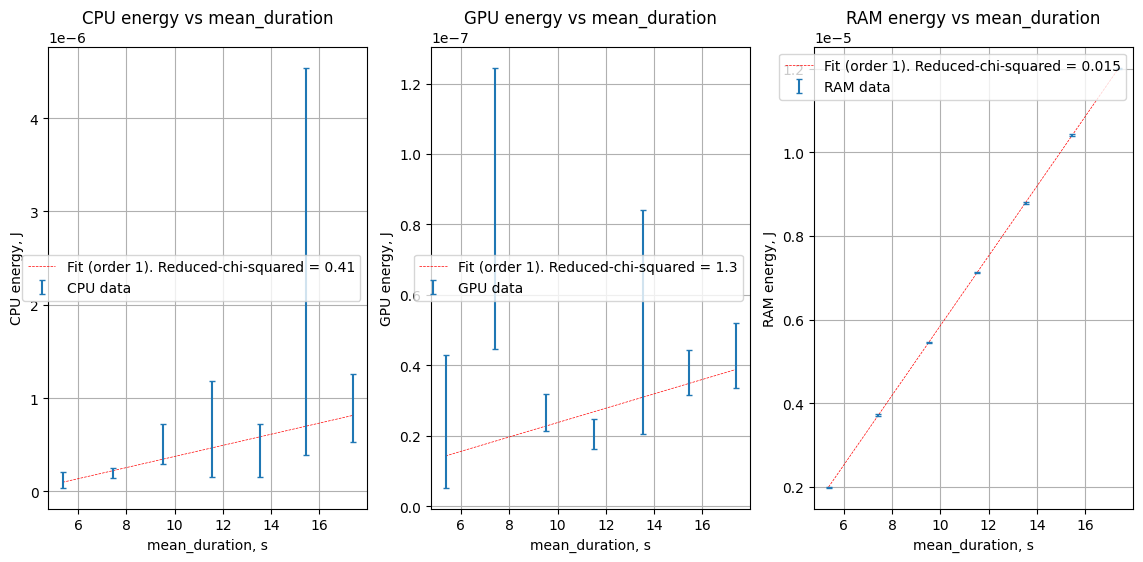

In [49]:
CPU_and_RAM_plotting(df, 'mean_duration', 'energy', fit=True, fit_order=1)

Now, lets demonstrate how CPU and RAM energy change with simulation intensity, by plotting average energy (J) consumption vs neutron number.

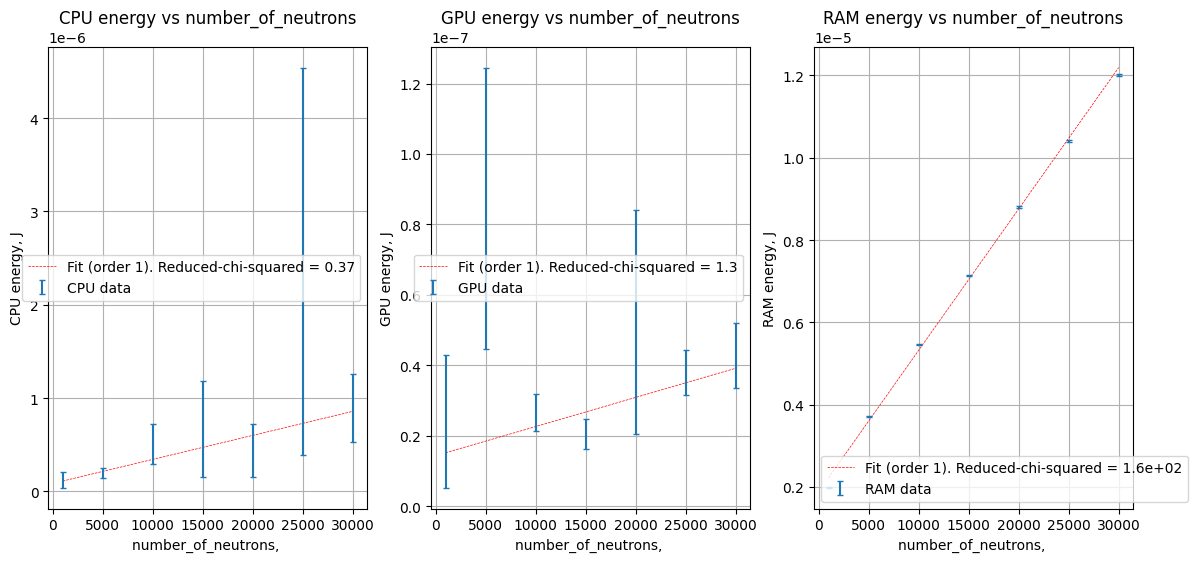

In [51]:
CPU_and_RAM_plotting(df, 'number_of_neutrons', 'energy', fit=True, fit_order=1)

Now, we will investigate the mean energy consumption of CPU/RAM per neutron simulated, with respect to the number of neutrons simulated at once. For fewer neutrons, the overhead involved with loading libraries and starting up the simulation is a relatively larger proportion of the energy consumption. However, as the number of neutrons simulated increases, this overhead is 'spread' over more neutrons, and is less significant when divided up amongst all of the neutrons. For a large enough number of neutrons, the overhead becomes negligible, and the energy consumption per neutron will start to plateau.

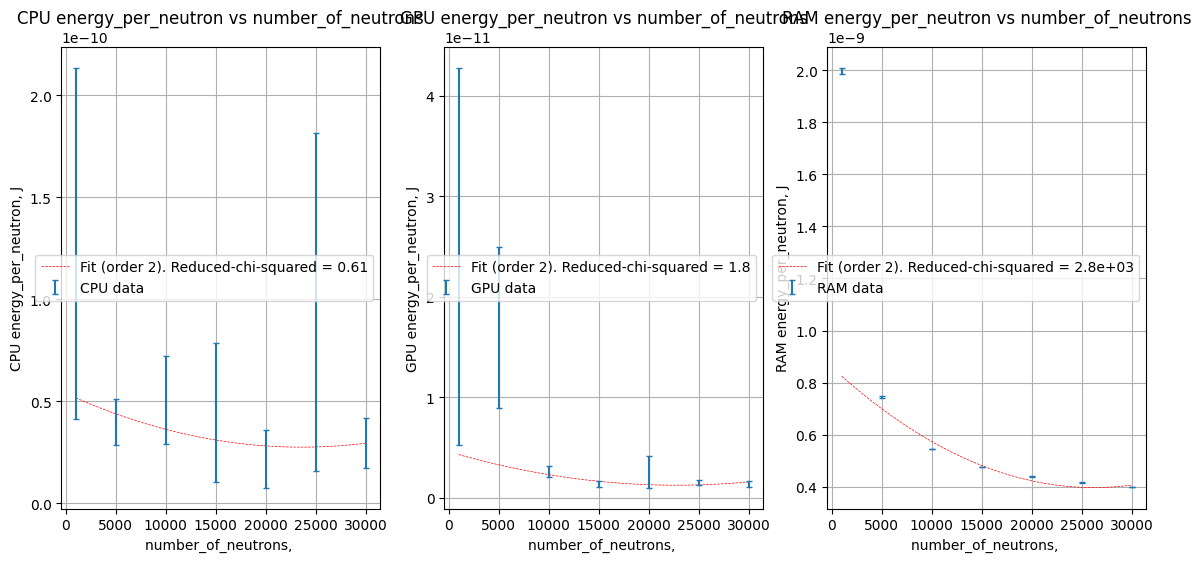

In [55]:
CPU_and_RAM_plotting(df, 'number_of_neutrons', 'energy_per_neutron', fit=True, fit_order=2)

# 2.2 Power consumption

Here we will demonstrate that power consumption remains constant with time, by plotting CPU and RAM power draw vs simulation duration. As previously discussed, CodeCarbon run on this particular device leads to fallback energy estimation models. Specifically, a constant power draw of 42.5W and 10W for the CPU and RAM respectively. Therefore, there is no variation in repeated measurements of power, and we observe constant power throughout all runs. There are no errorbars on the following plots, leading to an effectively infinite reduced chi squared value.

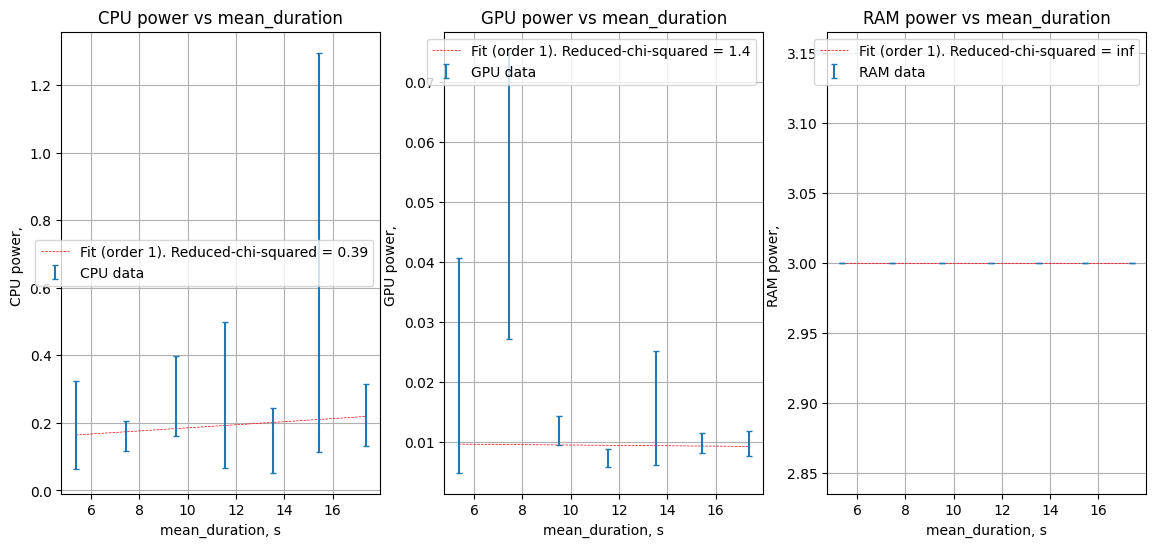

In [56]:
CPU_and_RAM_plotting(df, 'mean_duration', 'power', fit=True, fit_order=1)

Now, we can demonstrate how CPU/RAM power changes with simulation intensity (number of neutron). Again, a flat plot is observed due to the power draw of the CPU and RAM being approximated as constant by CodeCarbon.

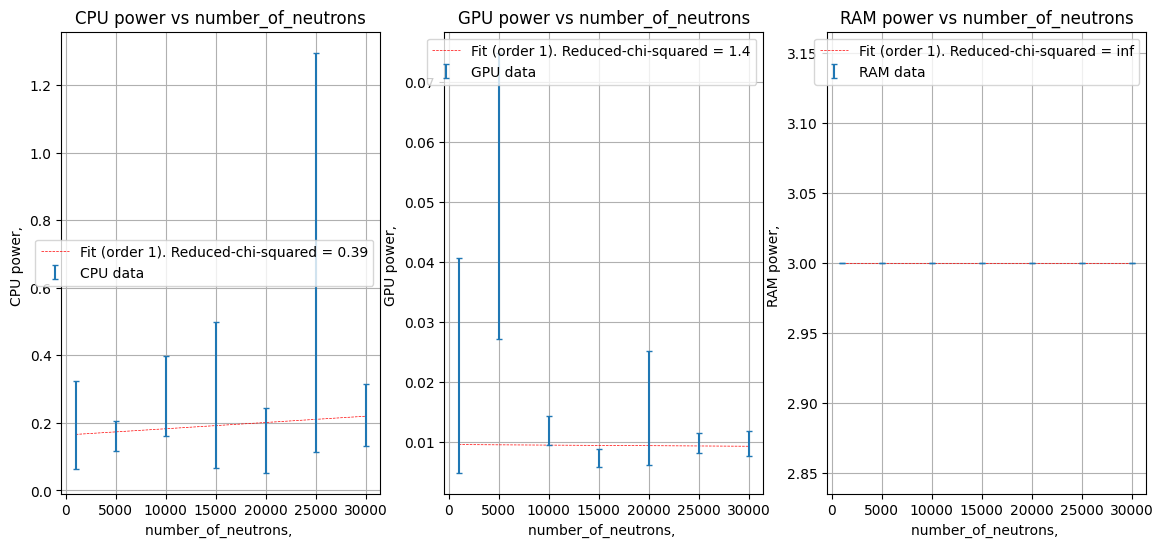

In [45]:
CPU_and_RAM_plotting(df, 'number_of_neutrons', 'power', fit=True, fit_order=1)

# 2.4 Emissions
Here we will plot how emissions change with respect to simulation complexity. The simulation emissions (gCO2e) are plotted with respect to neutron number. In order to calculate the emissions of a run, CodeCarbon uses the product of energy consumption and carbon intensity (or emissions rate). Regional carbon intensity data is used for USA and Canada (from www.iea.org), and the energy mix for a given country is used to calculate a carbon intensity value elsewhere (from www.globalpetrolprices.com). If the location is unknown, or carbon intensity data cannot be found from these sources, a default carbon intensity of 475 gCO2eq/kWh may be used. 

The plots below display scattered data, with a much smaller positive correlation between emissions and simulation runtime or number of neutrons, especially compared to the total energy consumption plots from Section 2.1. This is due to fluctuations in Carbon intensity whilst the simulations were being run. As can be seen in the raw data files (210725_neutron_penetration_emissions_NNNN.csv), the emissions_rate value fluctuated between 3.466e-8 and 3.466e-6 between runs. This variation creates larger errorbars, and whist some correlation remains, scatters the data points.


In [57]:
def emissions_plotter(df, x_variable, fit=False, fit_order=None):
    """
    Creates plot of emissions vs x_variable, with optional polyfit.

    Parameters:
    - df: pandas.DataFrame, containing the data to be plotted.
    - x_variable: string, name of x-axis variable from df for plotting
    - fit: bool, whether or not a polyfit should be performed. Default=False
    - fit_order: int, order of polynomial fit if fit=True. Default=None
    """

    #plot emissions data
    plt.figure()
    plt.errorbar(df[x_variable], df['mean_emissions'], yerr=df['emissions_err'], fmt="none", capsize=2, label = "Emissions data. (CPU power = 42.5W. RAM power = 10W.)")
    
    #perform polyfit if fit=True
    if fit:
        #raise error if fit=True but no fit_order is provided
        if fit_order==None:
            raise ValueError("Order of fit must be provided if fit=True.")
        
        if np.any(df['emissions_err'])==0.0: #do not use error-weighted fitting is errors=0
            coeffs = np.polyfit(df[x_variable], df['mean_emissions'], deg=fit_order)
        else: #use error-weighted fitting
            coeffs = np.polyfit(df[x_variable], df['mean_emissions'], deg=fit_order, w=1/df['emissions_err'])

        #perform polyfit
        poly = np.poly1d(coeffs)
        x_fit = np.linspace(df[x_variable].min(), df[x_variable].max(), 100)
        #calculate reduced chi squared
        chi = reduced_chi_squared(df[x_variable], df['mean_emissions'], df['emissions_err'], coeffs)

        #plot fit
        plt.plot(x_fit, poly(x_fit), 'r--', label=f"Fit (order {fit_order}). Reduced chi squared = {chi:.2g}", linewidth = 0.5)

    #set x label based on x_variable
    if x_variable=='mean_duration': plt.xlabel(f'Simulation run-time, s')
    else: plt.xlabel(f'{x_variable}')

    #plot details
    plt.ylabel('Emissions, kgCO2e')
    plt.title(f'Mean Emissions vs {x_variable} of Simulation')
    plt.grid()
    plt.legend()
    plt.show()
    return None

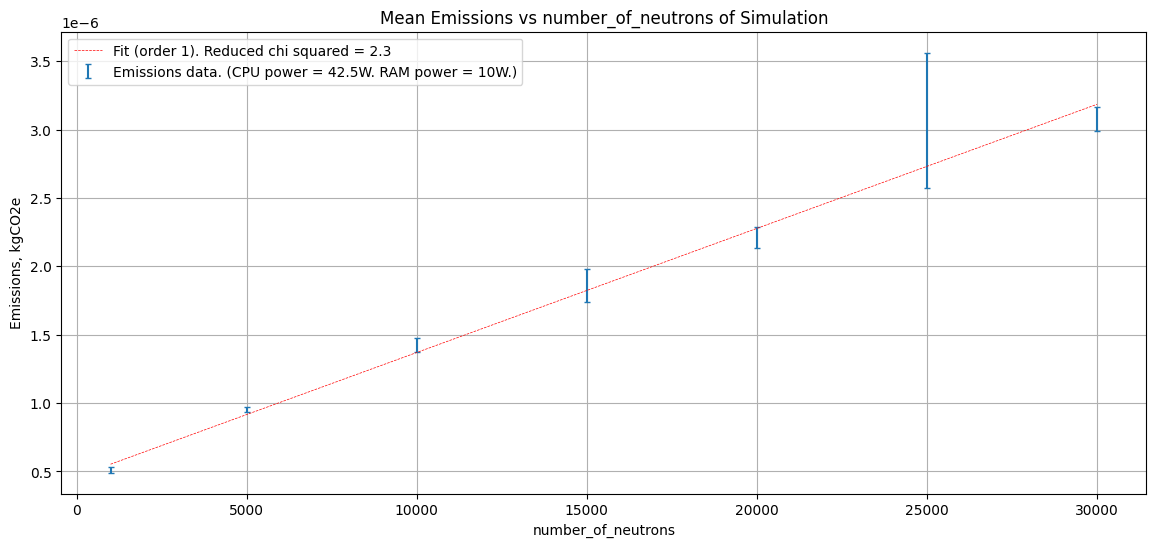

In [58]:
emissions_plotter(df, "number_of_neutrons", True, 1)

Now, we demonstrate how emissions change with runtime of simulation, by plotting the mean emissions (gCO2e) vs mean duration of simulation (s).

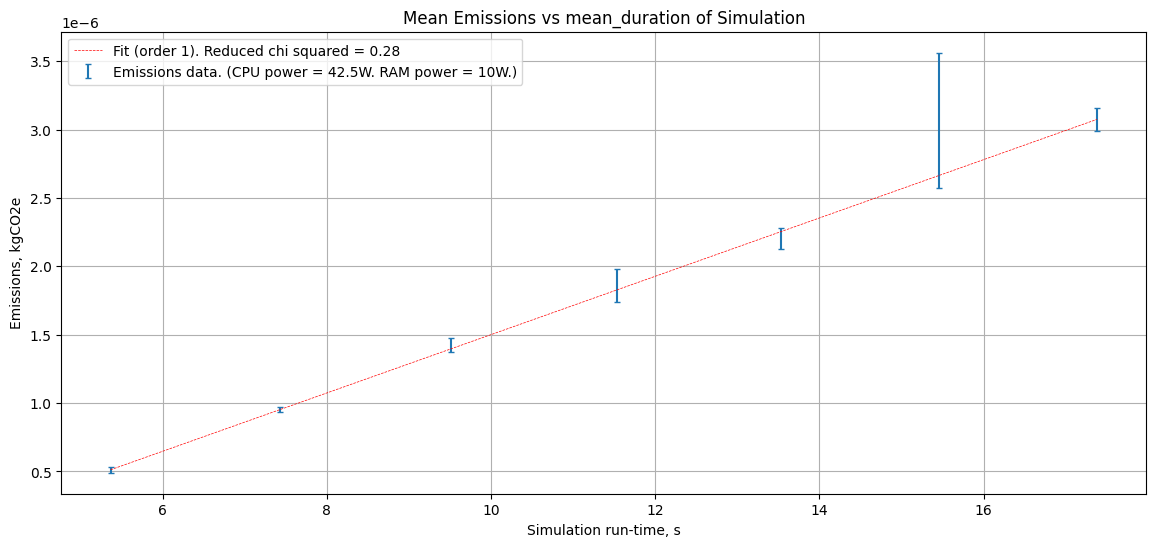

In [59]:
emissions_plotter(df, "mean_duration", True, 1)